In [1]:
import numpy as np
import pandas as pd
from confpred.cp import run_cp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from confpred import ConformalPredictor,SparseScore,SoftmaxScore, RAPSPredictor, RAPSScore
import os
import pickle
from sklearn.metrics import accuracy_score

/Users/margaridacampos/.pyenv/versions/3.11.6/envs/entmaxcp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_list = ['ImageNet','CIFAR10','NewsGroups','CIFAR100']
seed = '23'
model_loss = 'softmax'
alpha_list = np.round(np.linspace(0.01,0.1,10),4)
random_states = [1,12,123,1234,12345]
ROOT_DIR = '.'
score_list = ['limit','opt_entmax','RAPS','sparsemax','softmax','entmax']
transformation='logits'
summary_results = pd.DataFrame({'dataset':dataset_list})\
    .merge(pd.DataFrame({'random_state':random_states}), how = 'cross')\
        .merge(pd.DataFrame({'alpha':alpha_list}), how = 'cross')\
            .merge(pd.DataFrame({'score':score_list}), how = 'cross')
summary_results.set_index(['dataset','random_state','alpha','score'],inplace=True)
summary_results.sort_index(inplace=True)
summary_results_2 = pd.read_csv('../data/results_analysis/summary_results_v2.csv')

In [3]:
summary_results = pd.concat([summary_results.reset_index(),summary_results_2], axis=1)
summary_results['name'] = summary_results['score'].map({'RAPS':'RAPS',
                                                        'sparsemax':'sparsemax',
                                                        'opt_entmax':'opt-entmax',
                                                        'softmax':'InvProb',      
                                                        'limit':'log-margin',   
                                                        'entmax':'1.5-entmax'
                                                    },na_action="ignore")
summary_results

TypeError: the first argument must be callable

In [5]:
summary_results = pd.read_csv('../data/results_analysis/summary_results_v2.csv')
summary_results['name'] = summary_results['score'].map({'RAPS':'RAPS',
                                                        'sparsemax':'sparsemax',
                                                        'opt_entmax':'opt-entmax',
                                                        'softmax':'InvProb',      
                                                        'limit':'log-margin',   
                                                        'entmax':'1.5-entmax'
                                                    },na_action="ignore")

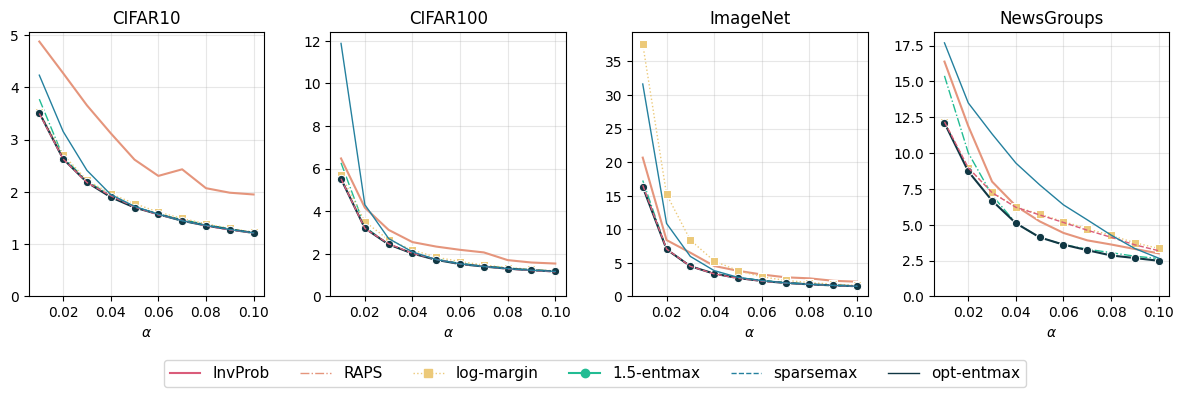

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Define custom linestyles, markers, and linewidths for each 'name'
custom_linestyles = {
    'InvProb': '-',           # Solid line
    'RAPS': '-.',             # Dash-dot line
    'log-margin': ':',        # Dotted line
    '1.5-entmax': '-',        # Solid line with markers
    'sparsemax': '--',  # Correct tuple format (offset, (dash, space))
    'opt-entmax': '-' # Correct tuple format (offset, pattern)
}

# Define markers for each 'name'
custom_markers = {
    'InvProb': None,       # Circle marker
    'RAPS': None,          # Square marker
    'log-margin': 's',    # Diamond marker
    '1.5-entmax': 'o',    # Circle marker
    'sparsemax': None,    # No marker
    'opt-entmax': None    # No marker
}

# Define linewidths for each 'name'
custom_linewidths = {
    'InvProb': 1.5,      # Thick line
    'RAPS': 1.0,         # Medium line
    'log-margin': 1,   # Medium line
    '1.5-entmax': 1.5,   # Thick line
    'sparsemax': 1,    # Medium-thin line
    'opt-entmax': 1    # Medium-thin line
}

# Custom color map dictionary
color_map = {
    'InvProb': '#da5c7a',    # Red
    'RAPS': '#e5957c',       # Orange
    'log-margin': '#ecc979', # Yellow
    '1.5-entmax': '#22bc93', # Teal
    'sparsemax': '#24809e',  # Blue
    'opt-entmax': '#103743'  # Dark blue
}

# Legend labels corresponding to the 'name' column
legend_labels = ['InvProb', 'RAPS', 'log-margin', '1.5-entmax', 'sparsemax', 'opt-entmax']

# Prepare the figure and axes
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

for index, var in enumerate(summary_results['dataset'].unique()):
    df = summary_results[summary_results['dataset'] == var]
    
    # Plot lines without automatic styling
    sns.lineplot(data=df, hue='name', x='alpha', y='avg_size', ax=axs[index], legend=False, palette=color_map,errorbar=None)

    # Manually set the linestyles, markers, and linewidths based on the custom dictionaries
    for line, label in zip(axs[index].lines, legend_labels):
        linestyle = custom_linestyles[label]
        marker = custom_markers[label]
        linewidth = custom_linewidths[label]

        # Apply linestyle and linewidth correctly
        if isinstance(linestyle, str):
            line.set_linestyle(linestyle)
        elif isinstance(linestyle, tuple) and isinstance(linestyle[1], (list, tuple)):
            line.set_dashes(linestyle)  # Apply dash pattern properly
        else:
            print(f"Warning: Invalid linestyle for {label}")

        # Apply marker only if it is not None
        if marker is not None:
            line.set_marker(marker)

        line.set_linewidth(linewidth)

    axs[index].set_ylabel('')
    axs[index].set_title(var)
    axs[index].set_ylim(bottom=0)
    axs[index].set_xlabel(r'$\alpha$')
    axs[index].grid(True, alpha=0.3)  # Add light grid lines

# Create custom legend handles for each line with markers
legend_handles = []
for label in legend_labels:
    linestyle = custom_linestyles[label]
    marker = custom_markers[label] if custom_markers[label] else ''
    
    if isinstance(linestyle, str):
        line = mlines.Line2D([], [], color=color_map[label], linestyle=linestyle,
                             marker=marker, linewidth=custom_linewidths[label])
    else:
        line = mlines.Line2D([], [], color=color_map[label], dashes=linestyle,
                             marker=marker, linewidth=custom_linewidths[label])

    legend_handles.append(line)

# Add the custom legend below the plot
fig.legend(handles=legend_handles, labels=legend_labels, title='', loc='lower center', ncol=6, fontsize=11, bbox_to_anchor=(0.5, 0))

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend below
plt.show()


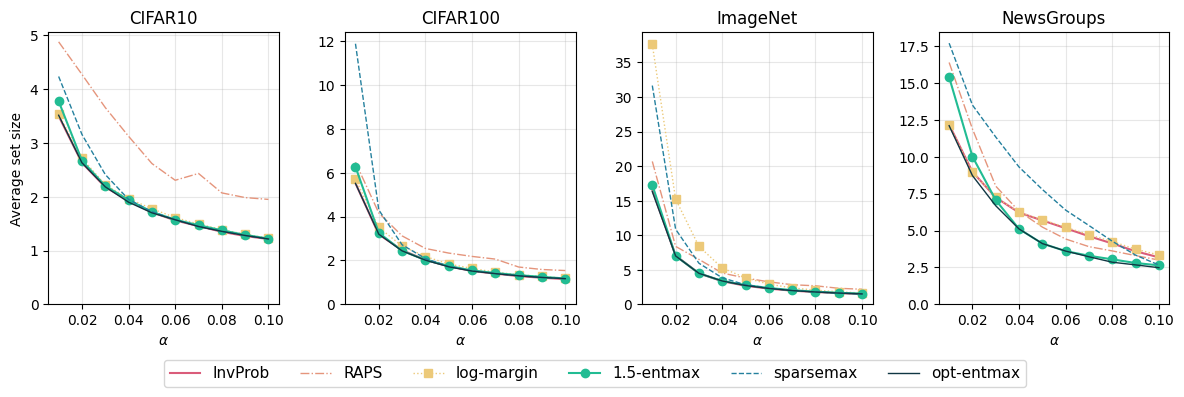

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Example style dictionaries
custom_linestyles = {
    'InvProb': '-',
    'RAPS': '-.',
    'log-margin': ':',
    '1.5-entmax': '-',
    'sparsemax': '--',
    'opt-entmax': '-'
}
custom_markers = {
    'InvProb': None,
    'RAPS': None,
    'log-margin': 's',
    '1.5-entmax': 'o',
    'sparsemax': None,
    'opt-entmax': None
}
custom_linewidths = {
    'InvProb': 1.5,
    'RAPS': 1.0,
    'log-margin': 1,
    '1.5-entmax': 1.5,
    'sparsemax': 1,
    'opt-entmax': 1
}
color_map = {
    'InvProb': '#da5c7a',
    'RAPS': '#e5957c',
    'log-margin': '#ecc979',
    '1.5-entmax': '#22bc93',
    'sparsemax': '#24809e',
    'opt-entmax': '#103743'
}
legend_labels = ['InvProb', 'RAPS', 'log-margin', '1.5-entmax', 'sparsemax', 'opt-entmax']

# --- Make sure summary_results has the columns dataset, name, alpha, avg_size ---
# summary_results = pd.read_csv("my_file.csv")  # or however you're loading your data

# Example figure with 4 subplots (one per dataset)
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
unique_datasets = summary_results['dataset'].unique()

for i, dataset_name in enumerate(unique_datasets):
    ax = axs[i]
    
    # Select rows for this dataset
    df_dataset = summary_results[summary_results['dataset'] == dataset_name]
    
    # Plot each method
    for method_name in legend_labels:
        # Filter just this method
        df_sub = df_dataset[df_dataset['name'] == method_name]
        
        # If multiple rows per alpha (e.g. seeds), average them
        df_agg = df_sub.groupby('alpha', as_index=False)['avg_size'].mean()
        
        # Plot one line
        ax.plot(
            df_agg['alpha'], 
            df_agg['avg_size'],
            color=color_map[method_name],
            linestyle=custom_linestyles[method_name],
            linewidth=custom_linewidths[method_name],
            marker=custom_markers[method_name] or '',
            label=method_name
        )
    
    ax.set_title(dataset_name)
    ax.set_xlabel(r'$\alpha$')
    # Only label the y-axis on the first subplot
    if i == 0:
        ax.set_ylabel('Average set size')
    else:
        ax.set_ylabel('')
    
    ax.set_ylim(bottom=0)
    ax.grid(True, alpha=0.3)

# Build a custom legend using matplotlib.lines.Line2D
legend_handles = []
for method_name in legend_labels:
    lh = mlines.Line2D(
        [], [], 
        color=color_map[method_name],
        linestyle=custom_linestyles[method_name],
        linewidth=custom_linewidths[method_name],
        marker=custom_markers[method_name] or '',
        label=method_name
    )
    legend_handles.append(lh)

fig.legend(
    handles=legend_handles, 
    labels=legend_labels,
    loc='lower center',
    ncol=6,
    bbox_to_anchor=(0.5, 0.0),
    fontsize=11
)

# Adjust layout so legend doesn't overlap subplots
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()


/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_8660/2232576139.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')
/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_8660/2232576139.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')
/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_8660/2232576139.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')


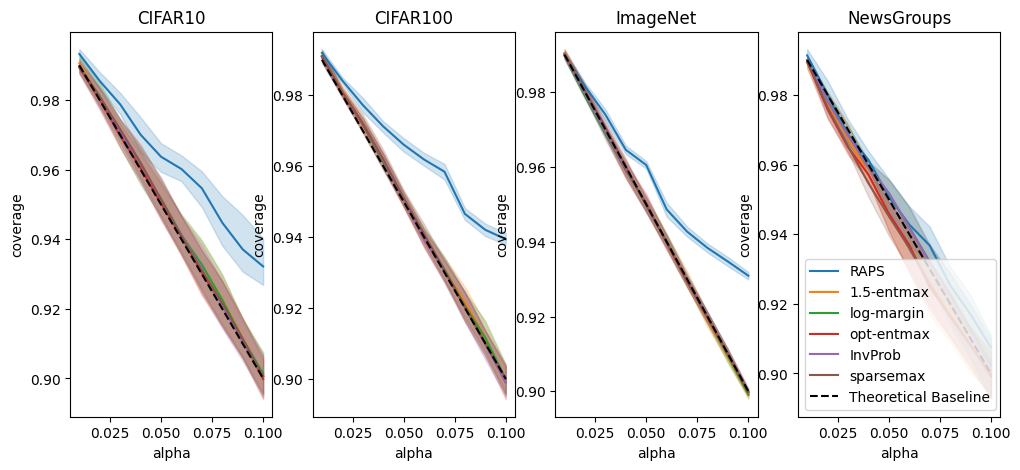

In [13]:
fig, axs = plt.subplots(1,4, figsize=(12,5))
for index, var in enumerate(summary_results['dataset'].unique()):
    df = summary_results[summary_results['dataset']==var]
    if index == len(summary_results['dataset'].unique())-1:
        sns.lineplot(df, hue = 'name',x = 'alpha',y='coverage', ax = axs[index])
    else: 
        sns.lineplot(df, hue = 'name',x = 'alpha',y='coverage', ax = axs[index], legend = False)  
    axs[index].plot([0.01,0.1],[0.99,0.9], label = 'Theoretical Baseline', c='black', linestyle = 'dashed')
  
    axs[index].set_title(var)
    axs[index].set_ylim
    plt.legend(title='')